# 3. Interpretabilidad de Modelos con LIME
## Predicción de Churn en Telecomunicaciones

**Objetivo**: Utilizar LIME (Local Interpretable Model-agnostic Explanations) para explicar las predicciones individuales de nuestros modelos de churn.

- Permite entender **por qué** el modelo hace una predicción específica.
- Identifica las características más influyentes para cada caso individual.
- Genera confianza en las predicciones del modelo.
- Ayuda a detectar posibles sesgos o errores del modelo.

---

## 3.1 Importación de Librerías

In [18]:
# Librerías
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import lime
import lime.lime_tabular
import importlib.metadata

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import joblib
# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 3.2 Carga de Datos y Modelo

In [19]:
# Cargar dataset limpio
df = pd.read_csv('../data/telco_churn_clean.csv')

# Preparar datos
X = df.drop('Churn', axis=1)
y = df['Churn'].map({'No': 0, 'Yes': 1})

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Cargar el mejor modelo
best_model = joblib.load('../app/model.joblib')
print(f"\n   Modelo cargado exitosamente")
print(f"Tipo de modelo: {type(best_model.named_steps['classifier']).__name__}")



   Modelo cargado exitosamente
Tipo de modelo: RandomForestClassifier


## 3.4 Configurar LIME Explainer

**LIME** requiere:
- Datos de entrenamiento **transformados** (numéricamente codificados)
- Nombres de las características transformadas
- Nombres de las clases

**Nota importante**: Como nuestro modelo usa un Pipeline con preprocesamiento (One-Hot Encoding para variables categóricas), necesitamos pasar a LIME los datos ya transformados, no los datos originales.

In [32]:
# Obtener el preprocesador del pipeline
preprocessor = best_model.named_steps['preprocessor']

# Transformar los datos de entrenamiento y prueba
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Obtener los nombres de las características después de la transformación
feature_names_transformed = preprocessor.get_feature_names_out()

print("TRANSFORMACIÓN DE DATOS PARA LIME")
print(f" Datos transformados correctamente")
print(f"\nDimensiones originales: {X_train.shape}")
print(f"Dimensiones transformadas: {X_train_transformed.shape}")
print(f"\nNúmero de características después de One-Hot Encoding: {len(feature_names_transformed)}")
print(f"\nPrimeras 10 características transformadas:")
for i, name in enumerate(feature_names_transformed[:10]):
    print(f"  {i+1}. {name}")


TRANSFORMACIÓN DE DATOS PARA LIME
 Datos transformados correctamente

Dimensiones originales: (5634, 19)
Dimensiones transformadas: (5634, 30)

Número de características después de One-Hot Encoding: 30

Primeras 10 características transformadas:
  1. num__SeniorCitizen
  2. num__tenure
  3. num__MonthlyCharges
  4. num__TotalCharges
  5. cat__gender_Male
  6. cat__Partner_Yes
  7. cat__Dependents_Yes
  8. cat__PhoneService_Yes
  9. cat__MultipleLines_No phone service
  10. cat__MultipleLines_Yes


In [33]:
# Crear el explainer de LIME con datos transformados
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_transformed,
    feature_names=feature_names_transformed,
    class_names=['No Churn', 'Churn'],
    mode='classification',
    random_state=RANDOM_STATE
)

print(f"\nCaracterísticas:")
print(f"  - Número de features transformadas: {len(feature_names_transformed)}")
print(f"  - Número de muestras de entrenamiento: {len(X_train_transformed)}")
print(f"  - Clases: ['No Churn', 'Churn']")
print(f"  - Modo: classification")



Características:
  - Número de features transformadas: 30
  - Número de muestras de entrenamiento: 5634
  - Clases: ['No Churn', 'Churn']
  - Modo: classification


## 3.5 Función de Predicción para LIME

In [35]:
# Crear función de predicción compatible con LIME
def predict_fn(X_transformed_array):
    # El clasificador ya espera datos transformados
    classifier = best_model.named_steps['classifier']
    probas = classifier.predict_proba(X_transformed_array)
    
    return probas

# Verificar que funciona
print("VERIFICACIÓN DE LA FUNCIÓN DE PREDICCIÓN")
sample = X_train_transformed[:5]
predictions = predict_fn(sample)
print(f" Función de predicción funcionando correctamente")
print(f"\nEjemplo de predicción para 5 muestras:")
print(predictions)
print(f"\nForma de salida: {predictions.shape}")


VERIFICACIÓN DE LA FUNCIÓN DE PREDICCIÓN
 Función de predicción funcionando correctamente

Ejemplo de predicción para 5 muestras:
[[0.64778112 0.35221888]
 [0.60604446 0.39395554]
 [0.94960091 0.05039909]
 [0.88976865 0.11023135]
 [0.30816248 0.69183752]]

Forma de salida: (5, 2)


## 3.6 Selección de Casos Representativos

Vamos a seleccionar 3 casos representativos para analizar:
1. **Caso 1**: Cliente con **alta probabilidad de churn** (predicción correcta)
2. **Caso 2**: Cliente con **baja probabilidad de churn** (predicción correcta)
3. **Caso 3**: Cliente con predicción **borderline** (probabilidad ~0.5)

In [ ]:
# Obtener predicciones para todo el conjunto de prueba (usando el modelo completo)
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Crear DataFrame con predicciones
predictions_df = pd.DataFrame({
    'Index': X_test.index,
    'True_Label': y_test.values,
    'Predicted_Label': y_pred,
    'Churn_Probability': y_proba,
    'Correct': y_test.values == y_pred
})

# Caso 1: Alta probabilidad de churn (correcto)
high_churn = predictions_df[(predictions_df['True_Label'] == 1) & 
                            (predictions_df['Correct'] == True) & 
                            (predictions_df['Churn_Probability'] > 0.8)].head(1)

# Caso 2: Baja probabilidad de churn (correcto)
low_churn = predictions_df[(predictions_df['True_Label'] == 0) & 
                           (predictions_df['Correct'] == True) & 
                           (predictions_df['Churn_Probability'] < 0.2)].head(1)

# Caso 3: Probabilidad borderline
borderline = predictions_df[(predictions_df['Churn_Probability'] > 0.45) & 
                            (predictions_df['Churn_Probability'] < 0.55)].head(1)

# Combinar casos
selected_cases = pd.concat([high_churn, low_churn, borderline])

print("CASOS SELECCIONADOS PARA EXPLICACIÓN")
print(selected_cases[['Index', 'True_Label', 'Predicted_Label', 'Churn_Probability', 'Correct']])

# Guardar índices y obtener las posiciones en X_test
case_indices = selected_cases['Index'].tolist()
case_positions = [X_test.index.get_loc(idx) for idx in case_indices]

print(f"\nÍndices de casos: {case_indices}")    
print(f"Posiciones en X_test: {case_positions}")


CASOS SELECCIONADOS PARA EXPLICACIÓN
    Index  True_Label  Predicted_Label  Churn_Probability  Correct
20   6529           1                1           0.848986     True
0     437           0                0           0.020957     True
3    4460           0                1           0.541133    False

Índices de casos: [6529, 437, 4460]
Posiciones en X_test: [20, 0, 3]


## 3.7 Explicación con LIME - Caso 1: Alta Probabilidad de Churn

In [37]:
# Seleccionar el primer caso
case_idx_1 = case_indices[0]
case_pos_1 = case_positions[0]
instance_1_transformed = X_test_transformed[case_pos_1]
instance_1_original = X_test.iloc[case_pos_1]
true_label_1 = y_test.iloc[case_pos_1]
pred_proba_1 = y_proba[case_pos_1]

print("CASO 1: CLIENTE CON ALTA PROBABILIDAD DE CHURN")
print(f"Índice del cliente: {case_idx_1}")
print(f"Etiqueta real: {'Churn' if true_label_1 == 1 else 'No Churn'}")
print(f"Probabilidad de Churn predicha: {pred_proba_1:.4f} ({pred_proba_1*100:.2f}%)")

print("\nCaracterísticas originales del cliente:")
for col, val in zip(X_test.columns, instance_1_original):
    print(f"  {col}: {val}")

# Generar explicación con LIME (usando datos transformados)
print("Explicación con LIME")

explanation_1 = explainer.explain_instance(
    data_row=instance_1_transformed,
    predict_fn=predict_fn,
    num_features=10,
    top_labels=2
)

print(" Explicación generada exitosamente")


CASO 1: CLIENTE CON ALTA PROBABILIDAD DE CHURN
Índice del cliente: 6529
Etiqueta real: Churn
Probabilidad de Churn predicha: 0.8490 (84.90%)

Características originales del cliente:
  gender: Male
  SeniorCitizen: 1
  Partner: No
  Dependents: No
  tenure: 2
  PhoneService: Yes
  MultipleLines: Yes
  InternetService: Fiber optic
  OnlineSecurity: No
  OnlineBackup: No
  DeviceProtection: No
  TechSupport: No
  StreamingTV: No
  StreamingMovies: No
  Contract: Month-to-month
  PaperlessBilling: Yes
  PaymentMethod: Mailed check
  MonthlyCharges: 74.85
  TotalCharges: 156.4
Explicación con LIME
 Explicación generada exitosamente
 Explicación generada exitosamente


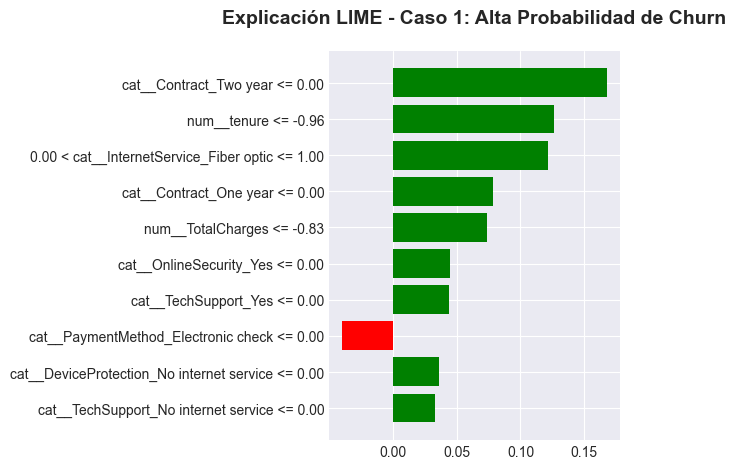

In [38]:
# Visualizar explicación - Caso 1
fig = explanation_1.as_pyplot_figure(label=1)
plt.title('Explicación LIME - Caso 1: Alta Probabilidad de Churn', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


### **Análisis LIME - Caso 1: Perfil Clásico de Alto Riesgo de Churn**

#### **Resumen del Caso**

| Índice Cliente | Etiqueta Real | Predicción del Modelo | Probabilidad de Churn |
| :--- | :---: | :---: | :---: |
| 6529 | Churn | Churn | **84.90%** |

El modelo predijo correctamente que este cliente se daría de baja, y lo hizo con un alto grado de confianza. LIME nos ayudará a entender exactamente qué características llevaron al modelo a esta conclusión.

#### **Perfil del Cliente**

Analizando sus datos originales, vemos un patrón muy claro:
*   **Contrato:** Mes a mes
*   **Antigüedad (Tenure):** Muy baja (solo 2 meses)
*   **Internet:** Fibra Óptica
*   **Servicios Adicionales:** No tiene contratado ninguno (sin seguridad, sin soporte técnico, etc.)
*   **Datos Demográficos:** Es un ciudadano senior, sin pareja ni dependientes.

#### **Interpretación de la Explicación LIME**

LIME confirma de manera contundente que el modelo ha identificado a este cliente como un caso de churn "de manual", basándose en los factores que ya habíamos identificado como críticos en el análisis visto anteriormente.

##### **Factores que AUMENTAN el Riesgo de Churn (Barras Verdes)**

1.  **Ausencia de Contrato a Largo Plazo (`Contract_Two year <= 0.00`):** Este es el factor más influyente. El hecho de no tener un contrato de dos años (y tampoco de un año, que es el cuarto factor más importante) le da al cliente la flexibilidad de irse en cualquier momento. El modelo lo identifica correctamente como el principal indicador de riesgo.

2.  **Antigüedad Muy Baja (`tenure <= -0.96`):** Con solo 2 meses, el cliente no ha desarrollado lealtad. Es el segundo factor más importante y refuerza la idea de que los primeros meses son críticos para la retención.

3.  **Servicio de Fibra Óptica (`InternetService_Fiber optic`):** Confirma nuestra sospecha de que este servicio, aunque premium, está fuertemente asociado al churn. Para este cliente, tener fibra óptica empuja significativamente la predicción hacia la baja.

4.  **Falta de Servicios de Valor Añadido (`OnlineSecurity_Yes <= 0.00`, `TechSupport_Yes <= 0.00`):** El modelo interpreta la ausencia de estos servicios como una señal de que el cliente no está "invertido" en el ecosistema de la empresa, lo que facilita su salida.

##### **Factores que DISMINUYEN el Riesgo de Churn (Barras Rojas)**

*   **Método de Pago (`PaymentMethod_Electronic check <= 0.00`):** Curiosamente, el único factor que juega ligeramente a su favor es **no** usar 'Cheque Electrónico'. Como vimos en el análisis global, el pago con cheque electrónico era un predictor de churn. Al no usarlo, este cliente elimina uno de los pequeños factores de riesgo, aunque su efecto es mínimo comparado con el peso abrumador de los factores negativos.

#### **Conclusión y Acción de Negocio**

Este cliente es el arquetipo del **"buscador de ofertas"**: se une por una promoción, contrata un servicio rápido (Fibra), no se compromete a largo plazo y no se integra en el ecosistema de la empresa.

La predicción del modelo no solo es correcta, sino que las razones son completamente lógicas. Para un cliente con este perfil, una intervención proactiva podría incluir:

*   Una **oferta exclusiva para firmar un contrato de 1 año** a cambio de un descuento en su tarifa mensual.
*   Ofrecerle un paquete de **`OnlineSecurity` gratuito durante 3 meses** para aumentar su dependencia de nuestros servicios y demostrar valor añadido.

## 3.8 Explicación con LIME - Caso 2: Baja Probabilidad de Churn

In [39]:
# Seleccionar el segundo caso
case_idx_2 = case_indices[1]
case_pos_2 = case_positions[1]
instance_2_transformed = X_test_transformed[case_pos_2]
instance_2_original = X_test.iloc[case_pos_2]
true_label_2 = y_test.iloc[case_pos_2]
pred_proba_2 = y_proba[case_pos_2]

print("CASO 2: CLIENTE CON BAJA PROBABILIDAD DE CHURN")
print(f"Índice del cliente: {case_idx_2}")
print(f"Etiqueta real: {'Churn' if true_label_2 == 1 else 'No Churn'}")
print(f"Probabilidad de Churn predicha: {pred_proba_2:.4f} ({pred_proba_2*100:.2f}%)")

print("\nCaracterísticas originales del cliente:")
for col, val in zip(X_test.columns, instance_2_original):
    print(f"  {col}: {val}")

# Generar explicación con LIME
print("Explicación con LIME")

explanation_2 = explainer.explain_instance(
    data_row=instance_2_transformed,
    predict_fn=predict_fn,
    num_features=10,
    top_labels=2
)


CASO 2: CLIENTE CON BAJA PROBABILIDAD DE CHURN
Índice del cliente: 437
Etiqueta real: No Churn
Probabilidad de Churn predicha: 0.0210 (2.10%)

Características originales del cliente:
  gender: Male
  SeniorCitizen: 0
  Partner: Yes
  Dependents: Yes
  tenure: 72
  PhoneService: Yes
  MultipleLines: Yes
  InternetService: Fiber optic
  OnlineSecurity: Yes
  OnlineBackup: Yes
  DeviceProtection: Yes
  TechSupport: Yes
  StreamingTV: Yes
  StreamingMovies: Yes
  Contract: Two year
  PaperlessBilling: Yes
  PaymentMethod: Credit card (automatic)
  MonthlyCharges: 114.05
  TotalCharges: 8468.2
Explicación con LIME


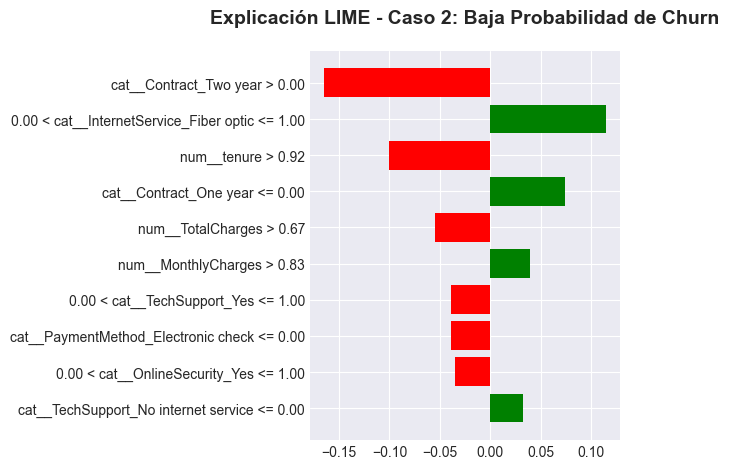

In [40]:
# Visualizar explicación - Caso 2
fig = explanation_2.as_pyplot_figure(label=1)
plt.title('Explicación LIME - Caso 2: Baja Probabilidad de Churn', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### **Análisis LIME - Caso 2: El Perfil del Cliente Leal**

#### **Resumen del Caso**

| Índice Cliente | Etiqueta Real | Predicción del Modelo | Probabilidad de Churn |
| :--- | :---: | :---: | :---: |
| 437 | No Churn | No Churn | **2.10%** |

En este caso, el modelo predijo correctamente que el cliente no se iría, y lo hizo con una confianza abrumadora (97.9% de probabilidad de quedarse). LIME nos muestra qué características le dan al modelo esta certeza.

#### **Perfil del Cliente**

Este cliente es la antítesis del caso anterior. Es un cliente de alto valor y profundamente integrado:
*   **Contrato:** Dos años
*   **Antigüedad (Tenure):** Máxima (72 meses)
*   **Servicios Adicionales:** Tiene contratado **todo** el catálogo de servicios (seguridad, backup, soporte, etc.).
*   **Método de Pago:** Tarjeta de crédito (automático).
*   **Internet:** Fibra Óptica (con un cargo mensual elevado).

#### **Interpretación de la Explicación LIME**

El gráfico de LIME muestra una "batalla" entre factores de lealtad muy fuertes y factores de riesgo conocidos. Afortunadamente para la empresa, los factores de lealtad ganan por goleada.

##### **Factores que DISMINUYEN el Riesgo de Churn (Barras Rojas)**

1.  **Contrato de Dos Años (`Contract_Two year > 0.00`):** De nuevo, el contrato es el rey. Este es el factor más poderoso que empuja la predicción hacia 'No Churn'. El modelo ha aprendido que un compromiso de dos años es la señal de lealtad definitiva.

2.  **Antigüedad Máxima (`tenure > 0.92`):** Este cliente, con 72 meses, se encuentra en el extremo más alto de la escala. Su larga historia con la compañía es la segunda señal más fuerte de que se quedará.

3.  **Integración en el Ecosistema (`TechSupport_Yes`, `OnlineSecurity_Yes`):** A diferencia del caso anterior, este cliente utiliza múltiples servicios de valor añadido. El modelo interpreta esto como una alta dependencia y satisfacción con el ecosistema de la empresa, reduciendo la probabilidad de que se vaya.

##### **Factores que AUMENTAN el Riesgo de Churn (Barras Verdes)**

Aquí es donde el análisis se pone interesante, ya que nos muestra las "presiones negativas" que incluso un cliente leal puede tener.

1.  **Servicio de Fibra Óptica (`InternetService_Fiber optic`):** Este es el hallazgo más importante. **Incluso para un cliente completamente leal, tener Fibra Óptica sigue siendo el principal factor de riesgo.** Esto refuerza la idea de que este producto, ya sea por su precio o por la percepción del servicio, ejerce una presión constante hacia el churn en todos los segmentos de clientes.

2.  **Cargos Mensuales Elevados (`MonthlyCharges > 0.83`):** Lógicamente, pagar una factura alta ($114.05) siempre será un factor que empuje, aunque sea ligeramente, a un cliente a reconsiderar su proveedor.

#### **Conclusión y Acción de Negocio**

Este cliente representa el **perfil ideal de cliente retenido**: comprometido a largo plazo y completamente integrado en la oferta de servicios. Las fuerzas que lo empujan a quedarse (contrato y antigüedad) son mucho más poderosas que las que lo empujan a irse (precio alto y tipo de internet).

La acción de negocio aquí no es de retención, sino de **estrategia y replicación**:

*   **Validación de Estrategia:** Este perfil valida que la estrategia de vender contratos a largo plazo y hacer "upselling" de servicios de valor añadido es extremadamente efectiva para la retención.
*   **Público Objetivo:** Este perfil debe ser el objetivo para las campañas de "upselling" dirigidas a clientes más nuevos. El objetivo es convertir a los clientes del "Caso 1" en clientes del "Caso 2".

## 3.9 Explicación con LIME - Caso 3: Probabilidad Borderline

In [ ]:
# Seleccionar el tercer caso
case_idx_3 = case_indices[2]
case_pos_3 = case_positions[2]
instance_3_transformed = X_test_transformed[case_pos_3]
instance_3_original = X_test.iloc[case_pos_3]
true_label_3 = y_test.iloc[case_pos_3]
pred_proba_3 = y_proba[case_pos_3]

print("CASO 3: CLIENTE CON PROBABILIDAD BORDERLINE (INCIERTO)")
print("="*80)
print(f"Índice del cliente: {case_idx_3}")
print(f"Etiqueta real: {'Churn' if true_label_3 == 1 else 'No Churn'}")
print(f"Probabilidad de Churn predicha: {pred_proba_3:.4f} ({pred_proba_3*100:.2f}%)")

print("\nCaracterísticas originales del cliente:")
for col, val in zip(X_test.columns, instance_3_original):
    print(f"  {col}: {val}")

# Generar explicación con LIME
print("Explicación con LIME")

explanation_3 = explainer.explain_instance(
    data_row=instance_3_transformed,
    predict_fn=predict_fn,
    num_features=10,
    top_labels=2
)


CASO 3: CLIENTE CON PROBABILIDAD BORDERLINE (INCIERTO)
Índice del cliente: 4460
Etiqueta real: No Churn
Probabilidad de Churn predicha: 0.5411 (54.11%)

Características originales del cliente:
  gender: Male
  SeniorCitizen: 0
  Partner: Yes
  Dependents: No
  tenure: 18
  PhoneService: Yes
  MultipleLines: No
  InternetService: Fiber optic
  OnlineSecurity: No
  OnlineBackup: No
  DeviceProtection: Yes
  TechSupport: Yes
  StreamingTV: No
  StreamingMovies: No
  Contract: Month-to-month
  PaperlessBilling: No
  PaymentMethod: Electronic check
  MonthlyCharges: 78.2
  TotalCharges: 1468.75

Generando explicación con LIME...
✓ Explicación generada exitosamente


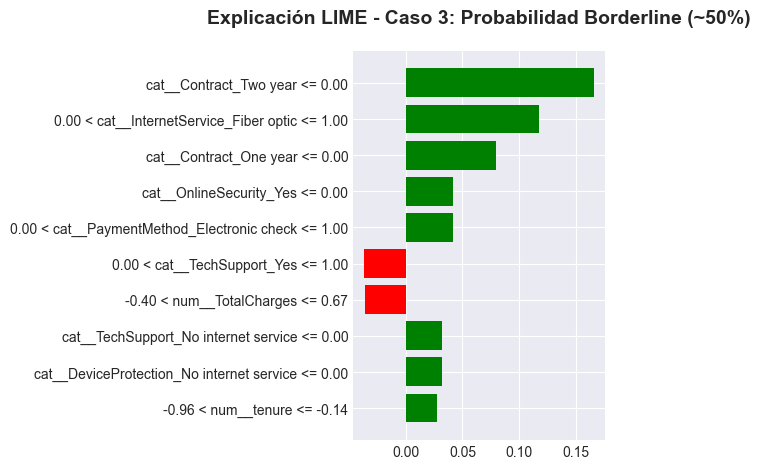

In [41]:
# Visualizar explicación - Caso 3
fig = explanation_3.as_pyplot_figure(label=1)
plt.title('Explicación LIME - Caso 3: Probabilidad Borderline (~50%)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### **Análisis LIME - Caso 3: El Cliente Indeciso (y un Error del Modelo)**

#### **Resumen del Caso**

| Índice Cliente | Etiqueta Real | Predicción del Modelo | Probabilidad de Churn | Resultado |
| :--- | :---: | :---: | :---: | :---: |
| 4460 | **No Churn** | Churn | **54.11%** | **Falso Positivo** |

Este caso es el más instructivo porque revela los límites del modelo y destaca el perfil de un cliente "en la cuerda floja". El modelo predijo que se iría (apenas por encima del umbral del 50%), pero en realidad, el cliente se quedó. LIME nos muestra el "tira y afloja" de características que causó esta incertidumbre y el eventual error.

#### **Perfil del Cliente**

Este cliente presenta una mezcla de características de alto riesgo y de lealtad:
*   **Factores de Riesgo:** Contrato mes a mes, usa Fibra Óptica, paga con cheque electrónico, no tiene seguridad online.
*   **Factores de Lealtad:** Antigüedad media (18 meses), tiene soporte técnico y protección de dispositivos.

#### **Interpretación de la Explicación LIME**

El gráfico de LIME visualiza perfectamente esta batalla interna. Hay muchas razones (verdes) para que el cliente se vaya, pero un par de razones importantes (rojas) para que se quede.

##### **Factores que AUMENTAN el Riesgo de Churn (Barras Verdes)**

1.  **Ausencia de Contrato a Largo Plazo (`Contract_Two year <= 0.00`):** Una vez más, este es el principal motor del riesgo. Al ser un cliente mes a mes, el modelo lo penaliza fuertemente.
2.  **Servicio de Fibra Óptica (`InternetService_Fiber optic`):** Es el segundo factor de riesgo más grande, lo que consolida su estatus como un producto problemático para la retención.
3.  **Pago con Cheque Electrónico y Sin Seguridad Online:** Estos dos factores, ya identificados como de riesgo, se suman a la predicción de churn.
4.  **Antigüedad Media (`tenure`):** Con 18 meses, ya no es un "novato", pero tampoco un veterano. El modelo ve su antigüedad como un factor de riesgo moderado, pero no tan fuerte como el de un cliente con 2 meses.

##### **Factores que DISMINUYEN el Riesgo de Churn (Barras Rojas)**

Aquí están las "anclas" que probablemente evitaron que el cliente se fuera en la vida real y que confundieron al modelo.

1.  **Tiene Soporte Técnico (`TechSupport_Yes`):** Este es el factor de lealtad más fuerte para este cliente. El hecho de que tenga contratado y probablemente use el soporte técnico es una señal de compromiso que el modelo reconoce y que contrarresta significativamente los factores negativos.
2.  **Cargos Totales (`TotalCharges`):** Aunque el efecto es menor, el hecho de que ya haya acumulado una cantidad considerable de cargos totales juega ligeramente a su favor.

#### **Conclusión y Acción de Negocio**

Este cliente es el **objetivo perfecto para una campaña de retención proactiva**.

*   **¿Por qué el modelo se equivocó?** Porque el cliente estaba verdaderamente en un punto de equilibrio. Los factores de lealtad (especialmente el tener soporte técnico) fueron en la vida real un poco más fuertes de lo que el modelo estimó, lo que resultó en que el cliente se quedara.

*   **¿Cuál es la oportunidad?** El modelo nos ha señalado a un cliente "rescatable". No es un detractor convencido, pero es vulnerable. Está "en la valla", y un pequeño empujón podría asegurarlo a largo plazo o, por el contrario, empujarlo a irse.

La acción de negocio aquí es clara y directa:

1.  **Contactar a este perfil de cliente:** Son los candidatos ideales para una llamada o un correo electrónico personalizado.
2.  **Atacar el principal factor de riesgo:** Ofrecerle un descuento atractivo para cambiarse de un contrato mes a mes a uno de **1 año**. Esto neutralizaría la mayor fuerza que lo empuja hacia el churn.
3.  **Reforzar sus puntos de anclaje:** Agradecerle su lealtad y quizás ofrecerle un servicio gratuito durante 6 meses como recompensa por tener ya `TechSupport`.
--- ---

## 3.10 Comparación de los Tres Casos

COMPARACIÓN DE LOS TRES CASOS
  Caso  Índice Etiqueta Real Prob. Churn  tenure MonthlyCharges       Contract           PaymentMethod
Caso 1    6529         Churn      0.8490       2         $74.85 Month-to-month            Mailed check
Caso 2     437      No Churn      0.0210      72        $114.05       Two year Credit card (automatic)
Caso 3    4460      No Churn      0.5411      18         $78.20 Month-to-month        Electronic check


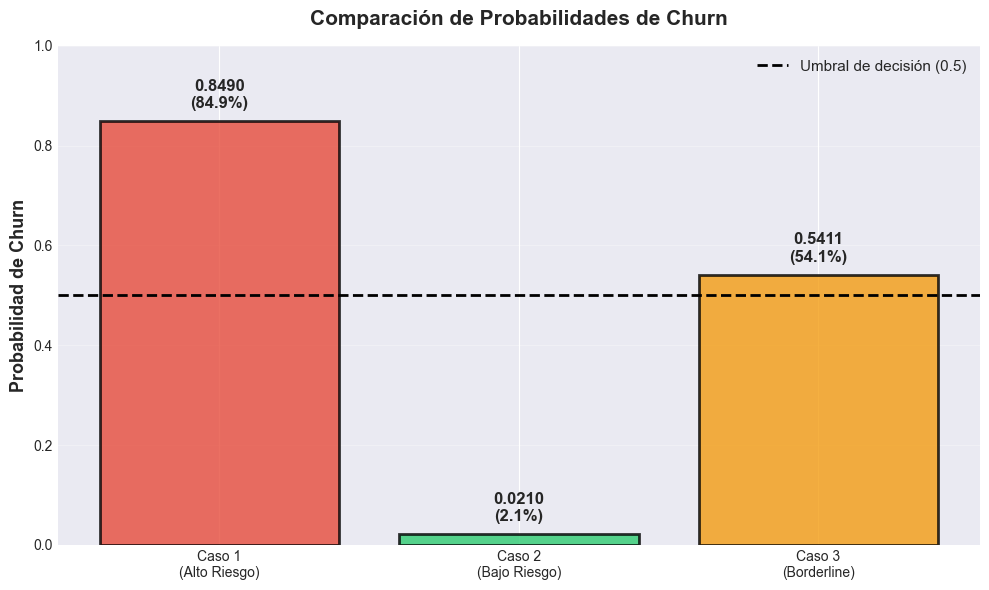

In [45]:
# Crear tabla comparativa
comparison_data = []

for idx, case_idx in enumerate(case_indices, 1):
    instance = X_test.loc[case_idx]
    true_label = y_test.loc[case_idx]
    pred_proba = y_proba[X_test.index.get_loc(case_idx)]
    
    comparison_data.append({
        'Caso': f'Caso {idx}',
        'Índice': case_idx,
        'Etiqueta Real': 'Churn' if true_label == 1 else 'No Churn',
        'Prob. Churn': f'{pred_proba:.4f}',
        'tenure': instance['tenure'],
        'MonthlyCharges': f"${instance['MonthlyCharges']:.2f}",
        'Contract': instance['Contract'],
        'PaymentMethod': instance['PaymentMethod']
    })

comparison_df = pd.DataFrame(comparison_data)

print("COMPARACIÓN DE LOS TRES CASOS")
print(comparison_df.to_string(index=False))

# Visualización comparativa
fig, ax = plt.subplots(figsize=(10, 6))

probas = [pred_proba_1, pred_proba_2, pred_proba_3]
colors_viz = ['#e74c3c' if p > 0.7 else '#f39c12' if p > 0.3 else '#2ecc71' for p in probas]
labels = [f'Caso 1\n(Alto Riesgo)', f'Caso 2\n(Bajo Riesgo)', f'Caso 3\n(Borderline)']

bars = ax.bar(labels, probas, color=colors_viz, alpha=0.8, edgecolor='black', linewidth=2)
ax.axhline(y=0.5, color='black', linestyle='--', linewidth=2, label='Umbral de decisión (0.5)')
ax.set_ylabel('Probabilidad de Churn', fontsize=13, fontweight='bold')
ax.set_title('Comparación de Probabilidades de Churn', fontsize=15, fontweight='bold', pad=15)
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)
ax.legend(fontsize=11)

# Añadir valores en las barras
for bar, proba in zip(bars, probas):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{proba:.4f}\n({proba*100:.1f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### **Conclusiones Finales del Análisis LIME: De la Confianza a la Oportunidad**

La tabla y el gráfico comparativo resumen de los tres perfiles de clientes que hemos analizado. Esta vista consolidada nos permite pasar de explicaciones individuales a una comprensión estratégica del comportamiento del modelo.

#### **Interpretación Estratégica**

La visualización de las probabilidades de churn no solo nos muestra la predicción del modelo, sino que también revela su **nivel de confianza**, lo cual es clave para la acción de negocio:

1.  **Caso 1 (Alto Riesgo - 84.9%): Confianza en la Alerta.**
    El modelo está muy seguro de esta predicción porque el perfil del cliente (baja antigüedad, contrato mes a mes) encaja perfectamente con los patrones de riesgo aprendidos. **Esto valida que el modelo identifica correctamente a los clientes de alto riesgo.**

2.  **Caso 2 (Bajo Riesgo - 2.1%): Confianza en la Lealtad.**
    La probabilidad es casi nula. El modelo tiene una certeza abrumadora de que este cliente se quedará, gracias a su contrato de dos años y su máxima antigüedad. **Esto genera confianza en que el modelo no generará falsas alarmas con nuestros clientes más valiosos y leales.**

3.  **Caso 3 (Borderline - 54.1%): La Incertidumbre es la Oportunidad.**
    Este es el insight más valioso. La probabilidad, apenas por encima del umbral del 50%, refleja la **indecisión del modelo**, que es un espejo de la **indecisión del cliente**. El modelo se equivocó (fue un Falso Positivo), pero nos ha hecho un favor enorme: **ha identificado a un cliente vulnerable pero recuperable.** Este cliente tiene factores de riesgo (contrato, pago) pero también anclas de lealtad (antigüedad media, servicios contratados).


## 3.11 Análisis de Sensibilidad: ¿Qué pasa si cambiamos una característica?

ANÁLISIS DE SENSIBILIDAD - CASO 1
¿Qué pasa si cambiamos el tipo de contrato del Caso 1?

Cliente Original:
  Contract: Month-to-month
  Probabilidad de Churn: 0.8490 (84.90%)

Si cambiamos a 'Month-to-month':
  Probabilidad de Churn: 0.8490 (84.90%)
  Cambio: +0.0000 (+0.00%)

Si cambiamos a 'One year':
  Probabilidad de Churn: 0.6513 (65.13%)
  Cambio: -0.1977 (-19.77%)

Si cambiamos a 'Two year':
  Probabilidad de Churn: 0.5346 (53.46%)
  Cambio: -0.3144 (-31.44%)



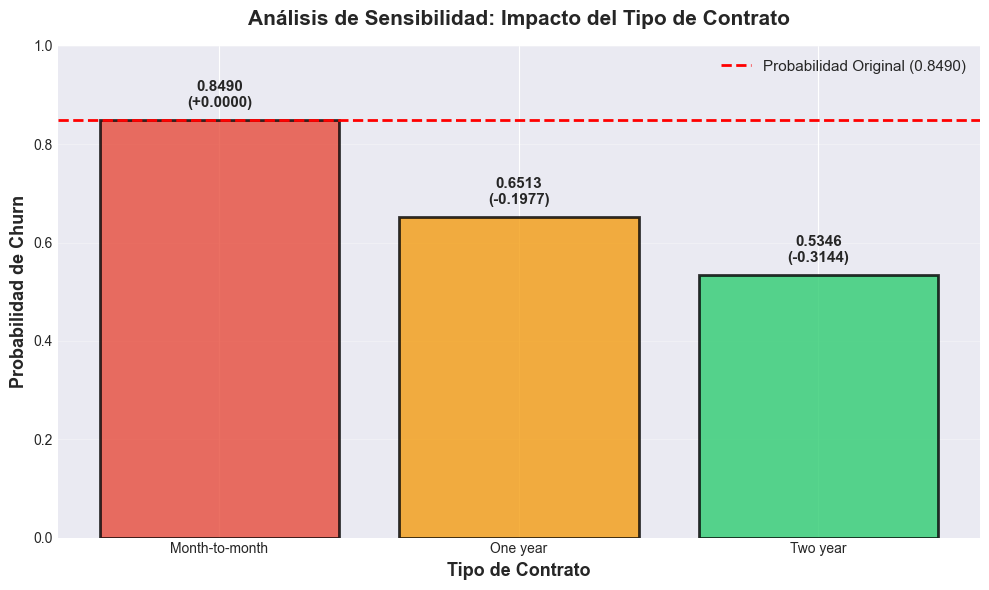

In [46]:
# Seleccionar Caso 1 (alto riesgo) y simular cambios
print("ANÁLISIS DE SENSIBILIDAD - CASO 1")
print("¿Qué pasa si cambiamos el tipo de contrato del Caso 1?\n")

# Cliente original (datos originales sin transformar)
original_instance = X_test.iloc[case_pos_1].copy()
original_proba = pred_proba_1

print(f"Cliente Original:")
print(f"  Contract: {original_instance['Contract']}")
print(f"  Probabilidad de Churn: {original_proba:.4f} ({original_proba*100:.2f}%)\n")

# Simular cambios de contrato
contract_options = ['Month-to-month', 'One year', 'Two year']
simulations = []

for contract_type in contract_options:
    # Modificar la instancia original
    modified_instance = original_instance.copy()
    modified_instance['Contract'] = contract_type
    
    # Crear DataFrame para pasar al modelo completo
    modified_df = pd.DataFrame([modified_instance])
    
    # Predecir con el modelo completo (incluye preprocesamiento)
    modified_proba = best_model.predict_proba(modified_df)[0][1]
    
    simulations.append({
        'Contract': contract_type,
        'Churn_Probability': modified_proba,
        'Change': modified_proba - original_proba
    })
    
    print(f"Si cambiamos a '{contract_type}':")
    print(f"  Probabilidad de Churn: {modified_proba:.4f} ({modified_proba*100:.2f}%)")
    print(f"  Cambio: {modified_proba - original_proba:+.4f} ({(modified_proba - original_proba)*100:+.2f}%)\n")

# Visualización
simulations_df = pd.DataFrame(simulations)

fig, ax = plt.subplots(figsize=(10, 6))
colors_sim = ['#e74c3c', '#f39c12', '#2ecc71']
bars = ax.bar(simulations_df['Contract'], simulations_df['Churn_Probability'], 
              color=colors_sim, alpha=0.8, edgecolor='black', linewidth=2)
ax.axhline(y=original_proba, color='red', linestyle='--', linewidth=2, 
           label=f'Probabilidad Original ({original_proba:.4f})')
ax.set_ylabel('Probabilidad de Churn', fontsize=13, fontweight='bold')
ax.set_xlabel('Tipo de Contrato', fontsize=13, fontweight='bold')
ax.set_title('Análisis de Sensibilidad: Impacto del Tipo de Contrato', fontsize=15, fontweight='bold', pad=15)
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)
ax.legend(fontsize=11)

for bar, row in zip(bars, simulations_df.itertuples()):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{row.Churn_Probability:.4f}\n({row.Change:+.4f})',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


### **Análisis de Sensibilidad: Cuantificando el Impacto de la Retención**

Después de entender *por qué* un cliente tiene un alto riesgo de churn, el siguiente paso es responder a la pregunta de negocio más importante: **"¿Qué podemos hacer al respecto y qué impacto tendría?"**

Para ello, realizamos un análisis de sensibilidad sobre el **Caso 1**, el cliente con una probabilidad de churn del **84.9%**. Simulamos un cambio en su característica más influyente, el **Tipo de Contrato**, para ver cómo reaccionaría el modelo.

#### **Escenario Simulado: "¿Y si le ofrecemos un contrato a largo plazo?"**

Manteniendo todas las demás características del cliente iguales, evaluamos cómo cambiaría su probabilidad de churn si aceptara un contrato de uno o dos años.

##### **Resultados de la Simulación**

| Escenario | Probabilidad de Churn | Reducción del Riesgo |
| :--- | :---: | :---: |
| **Original (Mes a mes)** | **84.90%** | (Línea Base) |
| Si cambia a **Contrato de 1 Año** | **65.13%** | **-19.77 puntos** |
| Si cambia a **Contrato de 2 Años** | **53.46%** | **-31.44 puntos** |

#### **Interpretación y Conclusión Estratégica**

El gráfico y los resultados de la simulación son increíblemente reveladores y proporcionan una justificación basada en datos para una estrategia de retención.

1.  **El Contrato es la Herramienta de Retención Más Poderosa:**
    El análisis cuantifica el inmenso poder del tipo de contrato. Simplemente cambiando esta única variable, podemos reducir drásticamente el riesgo percibido por el modelo.

2.  **De "Casi Perdido" a "Recuperable":**
    *   Al pasar a un **contrato de 1 año**, la probabilidad de churn del cliente baja casi 20 puntos. Sigue siendo un riesgo, pero pasa de ser una certeza a una probabilidad manejable.
    *   Al pasar a un **contrato de 2 años**, el riesgo se reduce en más de 30 puntos, llevándolo a un nivel "borderline" (53.46%). Para el modelo, este cambio transformaría a un cliente casi perdido en un cliente indeciso, lo cual es una victoria masiva.

3.  **Justificación del Retorno de la Inversión (ROI):**
    Este análisis es la base para justificar el costo de una campaña de retención. Ahora podemos decir, por ejemplo: "Si ofrecemos un descuento de $X para que un cliente de alto riesgo firme un contrato de 2 años, nuestro modelo estima que su probabilidad de irse disminuirá en un 31.44%. Esto nos permite calcular el valor esperado de la acción de retención".
--- ---

## 3.12 Resumen y Conclusiones del Análisis de Interpretabilidad

Este análisis ha logrado transformar nuestro modelo predictivo de una "caja negra" a una herramienta estratégica para la toma de decisiones. A través de LIME y el análisis de sensibilidad, no solo entendemos las predicciones, sino que también podemos simular el impacto de nuestras acciones.

### Principales Logros del Análisis

1.  **Entendimiento a Nivel Individual:** Se ha validado la capacidad de explicar el **porqué** detrás de la predicción de churn para cualquier cliente, identificando los factores específicos que impulsan su riesgo.

2.  **Validación de los Impulsores de Negocio:** Las explicaciones de LIME son consistentes con el análisis de importancia global, lo que genera una alta confianza en que el modelo ha aprendido los patrones de comportamiento correctos y no se basa en artefactos espurios.

3.  **Cuantificación del Impacto de las Acciones de Retención:** A través del análisis de sensibilidad ("what-if"), hemos demostrado la capacidad de **simular y medir** el efecto de acciones de negocio concretas, como cambiar el tipo de contrato de un cliente, proporcionando una base de datos para justificar el ROI de las campañas de retención.

### Impulsores de Churn vs. Anclas de Lealtad

El análisis confirma un perfil claro y consistente de los factores que mueven la aguja de la lealtad del cliente.

**Principales Impulsores de Riesgo:**
*   **Tipo de Contrato:** Ser un cliente `Month-to-month` es el predictor de riesgo más fuerte.
*   **Servicio de Internet:** Tener `Fiber Optic` se asocia consistentemente con un mayor riesgo.
*   **Baja Antigüedad (Tenure):** Los clientes con pocos meses son significativamente más volátiles.
*   **Método de Pago:** El uso de `Electronic check` es una señal de alerta.

**Principales Anclas de Lealtad:**
*   **Compromiso a Largo Plazo:** Un contrato de `Two year` es el indicador más poderoso de retención.
*   **Alta Antigüedad (Tenure):** Los clientes con más de 60 meses rara vez se van.
*   **Integración de Servicios:** Tener contratado `TechSupport` u `OnlineSecurity` actúa como un factor de anclaje.

### Estrategias Accionables Derivadas del Análisis

El verdadero valor de este análisis es su capacidad para generar y justificar acciones de negocio específicas.

1.  **Intervención Priorizada en Clientes "Indecisos":** Los clientes con probabilidades "borderline" (ej. 50-70%) son el objetivo principal para las campañas de retención. LIME demuestra que estos clientes tienen un balance de factores de riesgo y lealtad, haciéndolos los más persuadibles.

2.  **Justificación de Ofertas Basada en Datos:** El análisis de sensibilidad prueba que ofrecer a un cliente de alto riesgo un contrato de dos años puede reducir su probabilidad de churn en más de 30 puntos. Esta simulación sirve como justificación cuantitativa para diseñar ofertas de migración de contrato.

3.  **Investigación de Producto:** La recurrente aparición de `Fiber Optic` como un impulsor de churn, incluso en clientes leales, es un insight crítico. Se recomienda una investigación de producto o de satisfacción del cliente para entender la causa raíz (precio, estabilidad del servicio, expectativas del cliente).

### Valor y Consideraciones de LIME

*   **Valor Estratégico:** Proporciona transparencia, genera confianza en el modelo entre los stakeholders y, lo más importante, traduce las predicciones en acciones de negocio concretas.
*   **Consideraciones Técnicas:** Es importante recordar que LIME ofrece explicaciones locales (por cliente) y no globales. Su naturaleza estocástica puede generar ligeras variaciones, y su aplicación a gran escala puede ser computacionalmente intensiva.

---

**Conclusión Final:** El modelo ha evolucionado de ser un predictor a ser un simulador estratégico, permitiéndonos no solo anticipar el churn, sino también entender cómo prevenirlo de manera efectiva.